FSRCNN training data

In [1]:
import torch
import cv2
import h5py
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms
import torch.utils.data as dataf
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary
import math

In [2]:
file = 'FSRCNN_train_data.h5'
test_file = 'FSRCNN_test_data.h5'

In [3]:
with h5py.File(file,'r') as hf:
    data = np.array(hf.get('data'))
    label = np.array(hf.get('label'))
    print(data.shape)
    print(label.shape)

(4731, 1, 12, 12)
(4731, 1, 28, 28)


In [4]:
with h5py.File(test_file,'r') as hf:
    test_data = np.array(hf.get('data'))
    test_label = np.array(hf.get('label'))
    print(test_data.shape)
    print(test_label.shape)

(3427, 1, 12, 12)
(3427, 1, 28, 28)


In [3]:
class FSRCNN(nn.Module):
    def __init__(self,channel,d = 56,s = 12,m = 4):
        super(FSRCNN,self).__init__()
        
        #Feature Extraction
        self.first_part = nn.Sequential(
            nn.Conv2d(in_channels=channel,out_channels=d,kernel_size=3,stride=1,padding=0),
            nn.PReLU()
        )
        
        self.layers = []
        
        #Shrinking
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channels=d,out_channels=s,kernel_size=1,stride=1,padding=0),
            nn.PReLU()
        ))
        
        #Non-Linear Mapping
        for _ in range(m):
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels=s,out_channels=s,kernel_size=3,padding=1),
                nn.PReLU()
            ))
        
        #Expanding
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channels=s,out_channels=d,kernel_size=1,stride=1,padding=0),
            nn.PReLU()
        ))
        
        self.mid_part = torch.nn.Sequential(*self.layers)
        
        #Deconvolution
        self.last_part = nn.ConvTranspose2d(in_channels=d,out_channels=channel,kernel_size=9,stride=3,padding=4,output_padding=0)
        
    def forward(self,x):
        out = self.first_part(x)
        out = self.mid_part(out)
        out = self.last_part(out)
        return out
    
    def weight_init(self):
        for m in self.modules():

            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):

                # m.weight.data.normal_(0.0, 0.2)

                m.weight.data.normal_(0.0, sqrt(2/m.out_channels/m.kernel_size[0]/m.kernel_size[0])) # MSRA

                # nn.init.xavier_normal(m.weight) # Xavier

                if m.bias is not None:

                    m.bias.data.zero_()
            

In [6]:
model = FSRCNN(1)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

In [7]:
print(model)

FSRCNN(
  (first_part): Sequential(
    (0): Conv2d(1, 56, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (mid_part): Sequential(
    (0): Sequential(
      (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (1): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (2): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (3): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (4): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (5): Sequential(
      (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
      (1): PReLU(num_parameters=1)
    )
  )
  (last_part): ConvTranspose2d(56, 1,

In [8]:
from torchsummary import summary
summary(model,(1,12,12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 56, 10, 10]             560
             PReLU-2           [-1, 56, 10, 10]               1
            Conv2d-3           [-1, 12, 10, 10]             684
             PReLU-4           [-1, 12, 10, 10]               1
            Conv2d-5           [-1, 12, 10, 10]           1,308
             PReLU-6           [-1, 12, 10, 10]               1
            Conv2d-7           [-1, 12, 10, 10]           1,308
             PReLU-8           [-1, 12, 10, 10]               1
            Conv2d-9           [-1, 12, 10, 10]           1,308
            PReLU-10           [-1, 12, 10, 10]               1
           Conv2d-11           [-1, 12, 10, 10]           1,308
            PReLU-12           [-1, 12, 10, 10]               1
           Conv2d-13           [-1, 56, 10, 10]             728
            PReLU-14           [-1, 56,

In [9]:
epoches = 20 #20

In [10]:
train_data = torch.from_numpy(data) 
train_data = torch.tensor(train_data)
train_label = torch.from_numpy(label)
train_label = torch.tensor(train_label)
print(train_data.shape,train_label.shape)

torch.Size([4731, 1, 12, 12]) torch.Size([4731, 1, 28, 28])


In [11]:
test_data = torch.from_numpy(test_data) 
test_data = torch.tensor(test_data)
test_label = torch.from_numpy(test_label)
test_label = torch.tensor(test_label)
print(test_data.shape,test_label.shape)

torch.Size([3427, 1, 12, 12]) torch.Size([3427, 1, 28, 28])


In [12]:
dataset = dataf.TensorDataset(train_data,train_label)
test_dataset = dataf.TensorDataset(test_data,test_label)

In [13]:
loader = dataf.DataLoader(dataset,batch_size=32,shuffle=True)
test_loader = dataf.DataLoader(test_dataset,batch_size=32,shuffle=False)

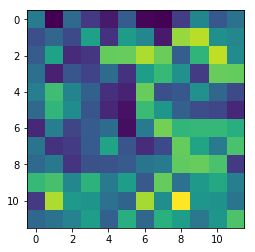

In [14]:
dataiter = iter(test_loader)
datas,labels = dataiter.next()
npimg = datas[0,:,:,:].numpy()
npimg = np.reshape(npimg,(12,12))
plt.imshow(npimg)
plt.show()

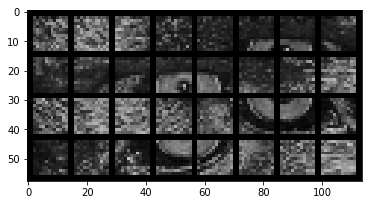

In [15]:
img = torchvision.utils.make_grid(datas)  #将32个batch的MNIST拼成一个图像
npimg = img.numpy()
np.shape(npimg)
plt.imshow(np.transpose(npimg, (1, 2, 0))) # (channel,pixel,pixel)-> (pixel,pixel,channel)
plt.show()

In [16]:
for epoch in range(epoches):
    print('epoch {}'.format(epoch + 1))
    print('*' * 10)
    running_loss = 0.0
    
    for i,data in enumerate(loader,1):
        lr_img,hr_img = data
        #print(type(lr_img),type(hr_img))  <class 'torch.Tensor'>
        #torch.Size([4731, 1, 12, 12]) torch.Size([4731, 1, 28, 28])
        
        lr_img = torch.tensor(lr_img,requires_grad = True)
        
        # forward
        out = model(lr_img)
        mse_loss = loss(out,hr_img)
        running_loss += mse_loss.item()
        
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()
        #if i%1000 == 0:
        #    print('[{}/{}] Loss: {:.6f}'.format(
        #        epoch + 1, epoches, running_loss))
    print('Finish {} epoch, Loss: {:.6f}'.format(
        epoch + 1, running_loss ))
    
    model.eval()
    running_loss1 = 0.0
    for data in test_loader:
        img, label = data
        img = torch.tensor(img,requires_grad = True)
        out = model(img)
        mse_loss1 = loss(out,label)
        running_loss1 += mse_loss.item()
       
        
        
    print('Test Loss: {:.6f}'.format(running_loss1))
    print()

epoch 1
**********
Finish 1 epoch, Loss: 3.424439
Test Loss: 1.054903

epoch 2
**********
Finish 2 epoch, Loss: 1.133683
Test Loss: 0.650623

epoch 3
**********
Finish 3 epoch, Loss: 0.940582
Test Loss: 0.687659

epoch 4
**********
Finish 4 epoch, Loss: 0.816618
Test Loss: 0.592697

epoch 5
**********
Finish 5 epoch, Loss: 0.732542
Test Loss: 0.550164

epoch 6
**********
Finish 6 epoch, Loss: 0.651976
Test Loss: 0.563535

epoch 7
**********
Finish 7 epoch, Loss: 0.657331
Test Loss: 0.343974

epoch 8
**********
Finish 8 epoch, Loss: 0.597393
Test Loss: 0.277764

epoch 9
**********
Finish 9 epoch, Loss: 0.631189
Test Loss: 0.447584

epoch 10
**********
Finish 10 epoch, Loss: 0.566539
Test Loss: 0.375977

epoch 11
**********
Finish 11 epoch, Loss: 0.568434
Test Loss: 0.515528

epoch 12
**********
Finish 12 epoch, Loss: 0.582761
Test Loss: 0.390725

epoch 13
**********
Finish 13 epoch, Loss: 0.547581
Test Loss: 0.377150

epoch 14
**********
Finish 14 epoch, Loss: 0.510216
Test Loss: 0.2713

In [17]:
testimg = 'Test/Set14/flowers.bmp'
img = cv2.imread(testimg,cv2.IMREAD_COLOR)
img.shape

(362, 500, 3)

In [18]:
torch.save(model,'FSRCNN.pkl')

D:\anaconda\envs\torch\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FSRCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [4]:
from PIL import Image
testimg = 'Test/Set14/flowers.bmp'
img = Image.open(testimg).convert('YCbCr')

In [5]:
y, cb, cr = img.split()
#input = torch.tensor(img).view(1, -1, img.size[1], img.size[0])
print(y, cb, cr)

<PIL.Image.Image image mode=L size=500x362 at 0x9BFF0B8> <PIL.Image.Image image mode=L size=500x362 at 0x9BFF0F0> <PIL.Image.Image image mode=L size=500x362 at 0x9BFF128>


In [6]:
transform1 = transforms.Compose([
    transforms.ToTensor(), 
   ]
)
img111 = transform1(y)

In [7]:
img = img111
type(img)

torch.Tensor

In [8]:
img = torch.tensor(img,requires_grad=True)
img.shape

torch.Size([1, 362, 500])

In [10]:
model = FSRCNN(1)
img = img.view(1,1,362,500)
out = model(img)

In [11]:
tt = transforms.ToPILImage()
img_out = tt(out.data[0])
img_out = img_out.convert('RGB')

In [12]:
out_img_y = out.data[0].numpy()

out_img_y *= 255.0

out_img_y = out_img_y.clip(0, 255)

out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')



out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)

out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)

out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')



out_img.save('ohno.jpg')

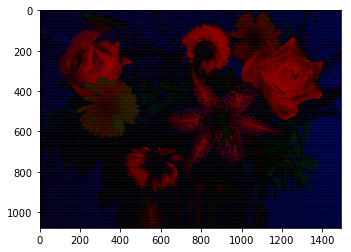

In [13]:
plt.imshow(out_img)
plt.show()